In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import h5py
import openfermion as of
from openfermion.transforms import qubit_operator_to_pauli_sum
from ansatz import CylicQAOAAnsatz
from hamlib_interface import print_hdf5_structure, read_graph_hdf5, read_openfermion_hdf5
from training import optimize_ansatz_random_start, cyclic_train
from maxcut import bitstring_energy

In [2]:
data_filename = "data/ham-graph-complete_bipart.hdf5"
print_hdf5_structure(data_filename)

 - complbipart-n-100_a-50_b-50 : /complbipart-n-100_a-50_b-50/
 [^^ DATASET ^^]
 - complbipart-n-10_a-5_b-5 : /complbipart-n-10_a-5_b-5/
 [^^ DATASET ^^]
 - complbipart-n-110_a-55_b-55 : /complbipart-n-110_a-55_b-55/
 [^^ DATASET ^^]
 - complbipart-n-120_a-60_b-60 : /complbipart-n-120_a-60_b-60/
 [^^ DATASET ^^]
 - complbipart-n-12_a-6_b-6 : /complbipart-n-12_a-6_b-6/
 [^^ DATASET ^^]
 - complbipart-n-130_a-65_b-65 : /complbipart-n-130_a-65_b-65/
 [^^ DATASET ^^]
 - complbipart-n-140_a-70_b-70 : /complbipart-n-140_a-70_b-70/
 [^^ DATASET ^^]
 - complbipart-n-14_a-7_b-7 : /complbipart-n-14_a-7_b-7/
 [^^ DATASET ^^]
 - complbipart-n-150_a-75_b-75 : /complbipart-n-150_a-75_b-75/
 [^^ DATASET ^^]
 - complbipart-n-160_a-80_b-80 : /complbipart-n-160_a-80_b-80/
 [^^ DATASET ^^]
 - complbipart-n-16_a-8_b-8 : /complbipart-n-16_a-8_b-8/
 [^^ DATASET ^^]
 - complbipart-n-170_a-85_b-85 : /complbipart-n-170_a-85_b-85/
 [^^ DATASET ^^]
 - complbipart-n-180_a-90_b-90 : /complbipart-n-180_a-90_b-90/
 

In [3]:
def maxcut_hamiltonian_to_graph(hamiltonian: of.QubitOperator) -> nx.Graph:
    graph = nx.Graph()
    psum = qubit_operator_to_pauli_sum(hamiltonian)
    for pstring in psum:
        if len(pstring.qubits) == 2:
            graph.add_edge(pstring.qubits[0], pstring.qubits[1])
    return graph

key = "complbipart-n-10_a-5_b-5"
hamiltonian = read_openfermion_hdf5(data_filename, key)
hamiltonian_psum = qubit_operator_to_pauli_sum(hamiltonian)
graph = maxcut_hamiltonian_to_graph(hamiltonian)
print(graph.edges)

[(cirq.LineQubit(5), cirq.LineQubit(0)), (cirq.LineQubit(5), cirq.LineQubit(1)), (cirq.LineQubit(5), cirq.LineQubit(2)), (cirq.LineQubit(5), cirq.LineQubit(3)), (cirq.LineQubit(5), cirq.LineQubit(4)), (cirq.LineQubit(0), cirq.LineQubit(6)), (cirq.LineQubit(0), cirq.LineQubit(7)), (cirq.LineQubit(0), cirq.LineQubit(8)), (cirq.LineQubit(0), cirq.LineQubit(9)), (cirq.LineQubit(6), cirq.LineQubit(1)), (cirq.LineQubit(6), cirq.LineQubit(2)), (cirq.LineQubit(6), cirq.LineQubit(3)), (cirq.LineQubit(6), cirq.LineQubit(4)), (cirq.LineQubit(7), cirq.LineQubit(1)), (cirq.LineQubit(7), cirq.LineQubit(2)), (cirq.LineQubit(7), cirq.LineQubit(3)), (cirq.LineQubit(7), cirq.LineQubit(4)), (cirq.LineQubit(8), cirq.LineQubit(1)), (cirq.LineQubit(8), cirq.LineQubit(2)), (cirq.LineQubit(8), cirq.LineQubit(3)), (cirq.LineQubit(8), cirq.LineQubit(4)), (cirq.LineQubit(9), cirq.LineQubit(1)), (cirq.LineQubit(9), cirq.LineQubit(2)), (cirq.LineQubit(9), cirq.LineQubit(3)), (cirq.LineQubit(9), cirq.LineQubit(4))]

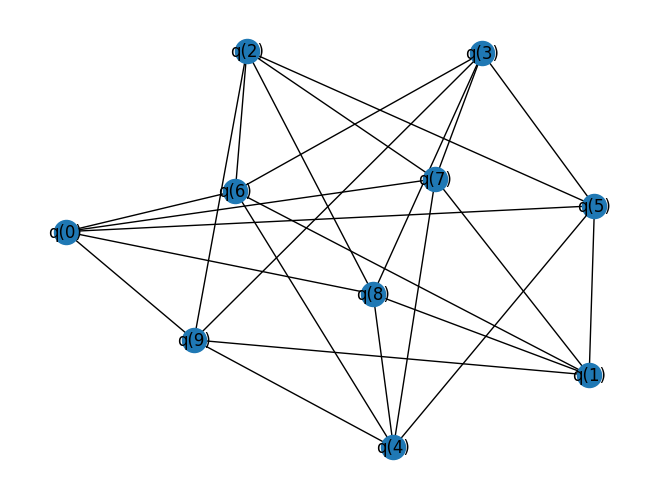

In [4]:
nx.draw(graph, with_labels=True)

In [5]:
n = len(graph.nodes)
p = 5
#alpha = np.linspace(2.0, 0.0, num=p)
#reference = [True] * n
ansatz = CylicQAOAAnsatz(graph, -1.0 * hamiltonian_psum)
result = optimize_ansatz_random_start(ansatz, p, 10)
print(result.energy)

-24.46764588356018


In [6]:
energies = []
bitstrings = ansatz.sample_bitstrings(result.gamma, result.beta, 10000)
for bstring in bitstrings:
    energy = bitstring_energy(bstring, hamiltonian_psum)
    energies.append(energy)
    #print(bstring, energy)

i_max = np.argmax(energies)
print("Maximum energy = ", energies[i_max])
print("Bitstring for maximum energy:\n", bitstrings[i_max])

Maximum energy =  25.0
Bitstring for maximum energy:
 [1 1 1 1 1 0 0 0 0 0]


In [7]:
rounds = 4
cyclic_result = cyclic_train(graph, -1.0 * hamiltonian_psum, p // rounds, rounds)
print("Energies for each step:\n", cyclic_result.energies)

Energies for each step:
 [-25.0, -25.0, -25.0, -25.0]


In [8]:
for ref in cyclic_result.references:
    print(ref)

[True, True, True, True, True, True, True, True, True, True]
[0 0 0 0 0 1 1 1 1 1]
[0 0 0 0 0 1 1 1 1 1]
[1 1 1 1 1 0 0 0 0 0]
